In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# BiLSTM (using GloVe embeddings)
## 'harmful' label

In [29]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
import emoji
import random

import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
import sys, os, re, csv, codecs
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
from inspect import signature
import text_utils

random.seed(42)

<IPython.core.display.Javascript object>

In [112]:
files_folder = (
    r"C:\Users\daniel.andrade\Documents\repos\social_media_text_classification\files"
)

<IPython.core.display.Javascript object>

In [113]:
df = pd.read_csv(files_folder + "\\test_data.csv")
df.head()

,comment,language,translation,harmful,harmful_type
0,"Эх, была б такая страна, а так придётся перепл...",ru,"Oh, there was such a country, and you have to ...",1,7
1,Jajajaja para eso se las compro al top manta,es,Hahahaha for that I buy them the top blanket,0,0
2,idomu ar cia fake,lt,This is a fake one,1,7
3,Usenme como botón de dislike,gl,Use me as a dislike button,1,7
4,Можна замовити?,uk,Can I order?,0,0


<IPython.core.display.Javascript object>

In [11]:
# drop missing values
df = df.dropna(how="any")

<IPython.core.display.Javascript object>

In [12]:
# demojize text
df["translation_clean"] = [emoji.demojize(x) for x in df["translation"]]

<IPython.core.display.Javascript object>

In [14]:
# clean comments
df["translation_clean"] = df["translation_clean"].apply(
    lambda x: text_utils.clean_text(x)
)

<IPython.core.display.Javascript object>

In [15]:
df.head()

,comment,language,translation,harmful,harmful_type,translation_clean
0,"Эх, была б такая страна, а так придётся перепл...",ru,"Oh, there was such a country, and you have to ...",1,7,oh country overpay
1,Jajajaja para eso se las compro al top manta,es,Hahahaha for that I buy them the top blanket,0,0,hahahaha buy top blanket
2,idomu ar cia fake,lt,This is a fake one,1,7,fake one
3,Usenme como botón de dislike,gl,Use me as a dislike button,1,7,use dislike button
4,Можна замовити?,uk,Can I order?,0,0,order


<IPython.core.display.Javascript object>

In [16]:
df.shape

(28076, 6)

<IPython.core.display.Javascript object>

In [19]:
df["l"] = df["translation"].apply(lambda x: len(str(x).split(" ")))
print("mean length of sentence: " + str(df.l.mean()))
print("max length of sentence: " + str(df.l.max()))
print("std dev length of sentence: " + str(df.l.std()))

mean length of sentence: 8.38545376834307
max length of sentence: 719
std dev length of sentence: 13.236868853213887


<IPython.core.display.Javascript object>

In [20]:
sequence_length = 50

<IPython.core.display.Javascript object>

In [93]:
max_features = 20000  # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=" ", oov_token="<unw>", filters=" ")
tokenizer.fit_on_texts(df["translation_clean"].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df["translation_clean"].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df["harmful"]).values

# lets keep a couple of thousand samples back as a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print("test set size " + str(len(X_test)))

test set size 2808


<IPython.core.display.Javascript object>

In [23]:
embeddings_index = {}
f = open(
    os.path.join(
        r"C:\Users\daniel.andrade\Documents\DANIEL\glove.6B", "glove.6B.100d.txt"
    ),
    encoding="utf8",
)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


<IPython.core.display.Javascript object>

In [24]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 15940 unique tokens.


<IPython.core.display.Javascript object>

In [ ]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

In [26]:
embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

<IPython.core.display.Javascript object>

In [102]:
model = Sequential()
model.add(
    Embedding(
        num_words,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=sequence_length,
        trainable=True,
    )
)

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.25))
model.add(Dense(units=y_train.shape[1], activation="sigmoid"))

adam = optimizers.Adam(lr=0.00001)

model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 100)           1594100   
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 50, 256)           234496    
_________________________________________________________________
dropout_40 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 1,993,206
Trainable params: 1,993,206
Non-trainable params: 0
___________________________________________

<IPython.core.display.Javascript object>

In [64]:
n_epochs = 100
batch_size = 128
callbacks = EarlyStopping(monitor="val_loss", patience=10, verbose=0)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=0.1,
    callbacks=[callbacks],
)

Train on 22741 samples, validate on 2527 samples
Epoch 1/100
22741/22741 [==============================] - 147s 6ms/step - loss: 0.6876 - acc: 0.5792 - val_loss: 0.6817 - val_acc: 0.6433
Epoch 2/100
22741/22741 [==============================] - 157s 7ms/step - loss: 0.6777 - acc: 0.6142 - val_loss: 0.6712 - val_acc: 0.6003
Epoch 3/100
22741/22741 [==============================] - 160s 7ms/step - loss: 0.6660 - acc: 0.6109 - val_loss: 0.6569 - val_acc: 0.6082
Epoch 4/100
22741/22741 [==============================] - 146s 6ms/step - loss: 0.6481 - acc: 0.6248 - val_loss: 0.6342 - val_acc: 0.6340
Epoch 5/100
22741/22741 [==============================] - 141s 6ms/step - loss: 0.6200 - acc: 0.6619 - val_loss: 0.6011 - val_acc: 0.6838
Epoch 6/100
22741/22741 [==============================] - 147s 6ms/step - loss: 0.5807 - acc: 0.7134 - val_loss: 0.5606 - val_acc: 0.7337
Epoch 7/100
22741/22741 [==============================] - 146s 6ms/step - loss: 0.5421 - acc: 0.7351 - val_loss: 0.5

22741/22741 [==============================] - 153s 7ms/step - loss: 0.3885 - acc: 0.8132 - val_loss: 0.4133 - val_acc: 0.7988
Epoch 60/100
22741/22741 [==============================] - 154s 7ms/step - loss: 0.3874 - acc: 0.8118 - val_loss: 0.4124 - val_acc: 0.7966
Epoch 61/100
22741/22741 [==============================] - 161s 7ms/step - loss: 0.3862 - acc: 0.8143 - val_loss: 0.4105 - val_acc: 0.7972
Epoch 62/100
22741/22741 [==============================] - 155s 7ms/step - loss: 0.3852 - acc: 0.8144 - val_loss: 0.4104 - val_acc: 0.7972
Epoch 63/100
22741/22741 [==============================] - 154s 7ms/step - loss: 0.3836 - acc: 0.8158 - val_loss: 0.4112 - val_acc: 0.7990
Epoch 64/100
22741/22741 [==============================] - 146s 6ms/step - loss: 0.3819 - acc: 0.8166 - val_loss: 0.4100 - val_acc: 0.7970
Epoch 65/100
22741/22741 [==============================] - 149s 7ms/step - loss: 0.3814 - acc: 0.8161 - val_loss: 0.4103 - val_acc: 0.8002
Epoch 66/100
22741/22741 [=======

<IPython.core.display.Javascript object>

In [69]:
# model.save(files_folder + "\\model_lstm_100_optimized.h5")

<IPython.core.display.Javascript object>

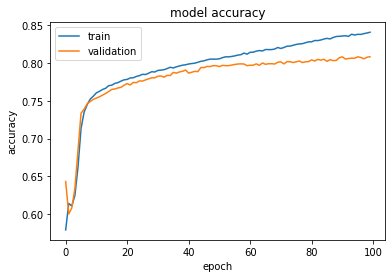

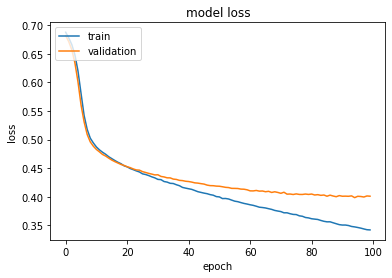

<IPython.core.display.Javascript object>

In [65]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [66]:
y_hat = model.predict(X_test)

<IPython.core.display.Javascript object>

In [67]:
accuracy_score(
    list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat))
)

0.801994301994302

<IPython.core.display.Javascript object>

Normalized confusion matrix


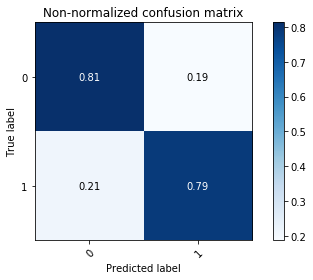

<IPython.core.display.Javascript object>

In [116]:
text_utils.plot_confusion_matrix(
    list(map(lambda x: np.argmax(x), y_test)),
    list(map(lambda x: np.argmax(x), y_hat)),
    normalize=True,
    classes=[0, 1],
    title="Normalized confusion matrix",
)
plt.show()

In [103]:
classif_report = classification_report(
    list(map(lambda x: np.argmax(x), y_test)),
    list(map(lambda x: np.argmax(x), y_hat)),
    output_dict=True,
)

classif_report_df = pd.DataFrame(classif_report).transpose()

<IPython.core.display.Javascript object>

In [104]:
classif_report_df

,f1-score,precision,recall,support
0,0.824716,0.836852,0.812927,1609.000000
1,0.772504,0.758233,0.787323,1199.000000
accuracy,0.801994,0.801994,0.801994,0.801994
macro avg,0.798610,0.797543,0.800125,2808.000000
weighted avg,0.802422,0.803282,0.801994,2808.000000


<IPython.core.display.Javascript object>